<a href="https://colab.research.google.com/github/thomascerbelaud/M2-IPE-data-energy/blob/main/notebooks/4_2_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 4.2: Time Series

The goal of thie notebook is to explore the concepts seen in class related to time series analysis and prediction.

## Download data and load

In [ ]:
import io
import glob
import os
import shutil
import tempfile
import tqdm
import warnings

import datetime as dt
import pandas as pd
from urllib.request import urlretrieve

warnings.filterwarnings("ignore", category=UserWarning)

urls = [
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2012.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2013.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2014.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2015.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2016.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2017.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2018.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2019.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2020.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2021.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2022.zip",
    "https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2023.zip",
]


def load_file_from_url(url: str) -> pd.DataFrame:
  with tempfile.TemporaryDirectory() as tempdir:
    # download
    zip_path = os.path.join(tempdir, "file.zip")
    urlretrieve(url, zip_path)

    # unpack and delete source
    shutil.unpack_archive(zip_path, tempdir)
    os.remove(zip_path)

    # load file
    filename = glob.glob(f"{tempdir}/*.xls")[0]
    df = pd.read_csv(filename, sep="\t", encoding="latin-1", parse_dates=True, low_memory=False)

    # clean columns
    columns = df.columns
    df.dropna(axis=1, how="all", inplace=True)
    df.columns = columns[1:]

    # index
    index = df.Date + df.Heures

    # filter only useful columns
    filter_columns = [
        'Consommation',
        'Fioul',
        'Charbon',
        'Gaz',
        'Nucléaire',
        'Eolien',
        'Solaire',
        'Hydraulique',
        'Pompage',
        'Bioénergies',
        'Ech. physiques',
        'Taux de Co2'
    ]
    df = df[filter_columns]

    # dropna
    mask = ~df.isnull().any(axis=1)
    df.dropna(axis=0, inplace=True)

    # parse index after dropna to avoid errors
    index = index.loc[mask].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d%H:%M"))
    df.index = index

  return df


def load_files_from_url_list(urls: list[str]) -> pd.DataFrame:
  dfs = []
  with tqdm.tqdm(urls, desc="Loading files from URL") as pbar_urls:
    for url in pbar_urls:
      dfs.append(load_file_from_url(url))

  df = pd.concat(dfs, axis=0)
  df.columns = ["cons", "oil", "coal", "gas", "nuclear", "wind", "solar", "hydro", "pump", "bioenergy", "import_export", "co2"]

  return df


df = load_files_from_url_list(urls)

In [ ]:
df.shape

# Time series analysis

Time series possess two main characteristics differentiating them from other data:
1. Data at time $t$ is dependent on previous time steps: this is called autocorrelation. Time-independent data do not display this kind of correlation, as usually we assume that each row in the dataset is sampled independently from other rows, and from the same distribution (i.i.d. assumption: independent and identically distributed).
2. Time series dimension is potentially infinite: indeed we observe a finite number of observations only because of time discretization.




### Resample

In [ ]:
# TODO: resample df at day-frequency "D", using pd.resample function
df_d = None

# Plot daily time series
se = df_d.co2
se.plot()

### Stationarity test

In this section, we use the Augmented-Dickie-Fuller (ADF) and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) statistical tests to test the series stationarity.

* ADF: $H_0$ is that the time series has a unit root, i.e. is not stationary
* KPSS: $H_0$ is that the time series is stationary around a constant

Remember that a statistical test is used to reject the null hypothesis. In other words, rejecting the null hypothesis $H_0$ allow us to conclude the time series is not stationary around a constant (for KPSS, and reversely for ADF), but the reverse is not true.

To wrap it up, a statistical test is rejected if $p_{\textrm{value}} < \alpha$, with alpha a significance level chosen by the modeler, typically in $\{0.05, 0.01, 0.001\}$, or even smaller to minimize the false positive rate.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# TODO: replace the kpss function with adfuller: do you see a difference between the two tests?
_, p_value, *_ = kpss(se)

# TODO: print the p_value. Assuming the significance level alpha = 5%, what can you conclude?
p_value

In [ ]:
from typing import Literal


def determine_integration_order(se: pd.Series, alpha: float = 0.05, max_diff_order: int = 5) -> int:
  """Sequentially apply the ADF test until the differentiated time series is stationary"""
  p_value = 0.0
  i = 0
  for i in range(max_diff_order + 1):
    # TODO: run ADF test and get p_value
    _, p_value, *_ = adfuller(se)
    print(p_value)

    if p_value < alpha:
      break

    se = se.diff().dropna()
  else:
    print(f"Time series is still non stationary after {max_diff_order} differentiations")
    return None

  return i

# TODO: test this function on a monthly resample time series. What do you see?
integration_order = determine_integration_order(se)
print(f"Series is stationary after {integration_order} differentiation(s).")

After running the last example, you should see that the test detect non stationarity for the monthly time series, but not the daily one. The ADF test only test for unit root and does not behave well with seasonality. This test is more adapted for time series where the seasonality, and possibly the trend, have been accounted for.

### Train test split

In time series, the train test split cannot be made naïvely by randomly choosing 20% of the dataset as test data. Instead, one need to preserve the autocorrelation of obserations with the past. To do so, the most simple split consists in choosing the end of the time series as a test.

A more advanced spitting strategy, not covered in this class, would be to split the dataset like in the `TimeSeriesSplit` scikit-learn implementation, which is the $k$-fold equivalent for time series.

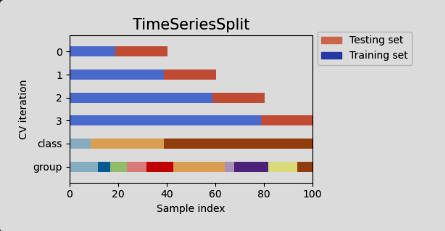

In [ ]:
# TODO: Split the data set in a train and test set, so that the test set is approximately
#  20% of the total dataset.
n = 1
df_train = None
df_test = None

## LOESS decomposition
One of the most common technique, however not particularly adapted to build a predictive model, is to use LOESS with varying window size to diaggregate a signal into its trend (low frequency), seasonal (mid-frequency) and noise (high frequency) parts.

$$ y(t) = t(t) + s(t) + ϵ(t) $$

In [ ]:
from statsmodels.tsa.seasonal import STL

# TODO: use STL with 2/3 of the series length for the trend smoother length.
#  Try changing these and see what's happen. Note the trend smoother needs to be an odd number.
trend_smoother_length = None
stl = STL(se, trend=trend_smoother_length)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(10, 8)

In [ ]:
# TODO: plot the ACF and PACF of the residuals
resid = stl.resid


## ARIMA models
ARIMA($p$, $d$, $q$) models are very popular linear models for time series, using autoregressive and moving average terms, plus differentiation (the I order). The order $p$ and $q$ can be determined by:
* Either using ACF and PACF plots. Order $p$ (AR) is determined by counting the number of lags for which the autocorrelation (ACF) is out of the confidence interval. Order $q$ i determined by counting the number of lags for which the partial autocorrelation (PCAF) is out of the confidence interval.
* Or by using information criterion, namely AIC or BIC. The process is the following: for each couple $(p, q)$ in a grid, train an ARIMA model and compute the information criterion. The best parameters are the one minimizing the information criterion.

In [ ]:
from typing import Any

import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX


def train_sarimax(se: pd.Series, p: int, d: int, q: int, s: int, *, plot_diagnosis: bool = True, predictors: pd.DataFrame | None = None) -> Any:
  sarimax = SARIMAX(
      se,
      order=(p, d, q),
      seasonal_order=(1, 0, 0, s),
      trend="c",
      exog=predictors,
  )
  res = sarimax.fit()

  if plot_diagnosis:
    plot_acf(res.resid);
    plot_pacf(res.resid);
    plt.show()
    plt.plot(res.resid)

  return res


def predict_sarimax(trained_model: Any, horizon: int, predictors: pd.DataFrame | None) -> pd.DataFrame:
  forecast = res.get_forecast(steps=horizon, exog=predictors)
  return forecast


def plot_predictions(trained_model: Any, se: pd.Series, horizon: int, plot_ci: bool = False, predictors: pd.DataFrame | None = None) -> None:
  plt.plot(se.iloc[-horizon*4:])
  forecast = predict_sarimax(res, horizon, predictors)
  plt.plot(forecast.predicted_mean)

  if plot_ci:
    ci = forecast.conf_int()
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=.5)

  plt.plot(df_test.co2.iloc[:horizon])

  plt.legend(["History", "Forecast", "Prediction interval", "Ground truth"])
  plt.ylabel("CO$_2$ [g/kWh]")

### Without predictors

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# TODO: plot the ACF and PACF function of the series se

In [ ]:
# TODO: determine the order p and q using the ACF and PACF plot. For each
#  Fit, analyze the residuals to validate the choice of p and q. You should notice
#  a seasonal effect s in the PACF and ACF. Determine s as well.
p = 4
q = 4
s = 7
trained_model = None

In [ ]:
# TODO: plot the forecast for the next 30 days. How good are the predictions?
horizon = 30

### With predictors

In [ ]:
# TODO: determine the order p and q using the ACF and PACF plot. For each
#  Fit, analyze the residuals to validate the choice of p and q. You should notice
#  a seasonal effect s in the PACF and ACF. Determine s as well.
p = 4
q = 4
s = 7
se = df_train.co2
predictors = df_train.iloc[:, :-1]  # co2 is the last column

In [ ]:
# TODO: plot the forecast for the next 30 days. How do the predictions compare
#  with the case when no predictors were used? Was it expected?
horizon = 30
predictors = df_test.iloc[:, :-1]

## Prophet
$$ y(t) = g(t) + s(t) + h(t) + ϵ_t $$

With $y$ the observations, $g$ the growth or trend function, $s$ the seasonality function, $h$ the holiday function, and $ϵ_t$ the noise. This model is a generalized additive model (GAM). One of its strength is that, during training, it infers changepoints in the series, allowing it to change regime it is additive parts. Furthermore, under the hoods, it accounts for holidays and can add regressors to the model, same as SARIMAX.

Under the hood, this model uses Bayesian inference for its parameters (incl. changepoints) learning. It can model non linear phenomena.

In [ ]:
from prophet import Prophet


def train_prophet(se: pd.Series, predictors: pd.DataFrame | None = None) -> Prophet:
  # prepare data using prophet conventions
  df = se.reset_index()
  df.columns = ["ds", "y"]

  # fit model
  m = Prophet()
  if predictors is not None:
    for name, col in predictors.items():
      m.add_regressor(name)
      df[name] = col.to_numpy()

  m.fit(df)

  return m


def predict_prophet(m: Prophet, predictors: pd.DataFrame) -> pd.DataFrame:
  predictors.index.name = "ds"
  return m.predict(predictors.reset_index())


def plot_forecast(m: Prophet, y: pd.DataFrame, forecast: pd.DataFrame) -> None:
  m.plot(forecast)
  y.plot(c=sns.color_palette()[1], alpha=.5, label="True")
  plt.legend()


In [ ]:
%%time
# TODO: train a GAM model (Prophet)
se = df_train.iloc[:, -1]
predictors = df_train.iloc[:, :-1]
m = None

In [ ]:
# TODO/ forecast and plot on the whole test set
forecast = None


# Predictor training

Let us wrap everything to train multiple predictors and assessing their performance on a test set.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error


def generate_pdqs_grid() -> list[list[int]]:
  """Generate grids of orders to trains SARIMAX models, in order to select the best one
  based on informations criterions. To limit the computational burden, the grid is
  voluntarily small."""
  prange = range(4, 5)
  drange = range(1, 2)
  qrange = range(4, 5)
  srange = range(7, 8)
  return [
      [p, d, q, s] for p in prange for d in drange for q in qrange for s in srange
  ]


def train_sarimax_cv(se: pd.Series, orders: list[int], predictors: pd.DataFrame) -> res:
  """Fit multiple SARIMAX model and select the best based on the AIC"""
  best_model = None
  best_aic = None
  best_order = None
  for order in orders:
    print(f"Train {order=}")
    p, d, q, s = order
    res = train_sarimax(se, p, d, q, s, predictors=predictors, plot_diagnosis=False)
    if best_model is None or res.aic < best_aic:
      print(f"AIC improved from {best_aic} to new_aic={res.aic}")
      best_model = res
      best_aic = res.aic
      best_order = order

  print(f"The best model has {best_order=} with {best_aic=}")
  return best_model


def run_experiment(df, n_splits: int = 2) -> None:
  # train test split
  splitter = TimeSeriesSplit(n_splits=n_splits)

  # split df
  X = df.iloc[:, :-1]
  y = df.iloc[:, -1]

  sarimax_grid_search = generate_pdqs_grid()

  results = {}

  for i, (train_idx, test_idx) in enumerate(splitter.split(X)):
    print(f"Fold {i}")
    # TODO: split train and test set
    X_train = None
    y_train = None
    X_test = None
    y_test = None

    sarimax_model = train_sarimax_cv(y_train, sarimax_grid_search, predictors=X_train)
    prophet_model = train_prophet(y_train, X_train)

    horizon = len(y_test)
    y_pred_sarimax = predict_sarimax(sarimax_model, horizon, predictors=X_test).predicted_mean
    y_pred_prophet = predict_prophet(prophet_model, X_test).yhat

    results[f"Fold {i}"] = {
        "MAPE": {
            # TODO: compute the MAPE, mean_absolute_percentage_error
            "SARIMAX": None,
            "Prophet": None,
        }

    }

  return results


# TODO: run the experiments. What are your conclusions?
# You can try with a larger grid search for SARIMAX models.
# You can also try increasing the number of folds
results = run_experiment(df_d)


In [ ]:
results